# Go言語で整数を5バイトに押し込む簡単なお仕事

## はじめに

ビックデータを処理するような場合、データの読み込みが律速になることが多いです。その場合、データのストレージ上のサイズが小さくなると読み込み時間が減り、全体の処理時間が半分になったりします。そんな時、整数が40bitで十分ならば、40bitで保持したいですね。というわけで、Go言語で整数を40bitでストレージに読み書きする方法について調べました。

まずは、Go言語をインストールします。

In [ ]:
!wget https://golang.org/dl/go1.17.2.linux-amd64.tar.gz
!tar -C /usr/local -xzf go1.17.2.linux-amd64.tar.gz

import os
os.environ['PATH'] += ":/usr/local/go/bin"

--2021-11-06 04:56:26--  https://golang.org/dl/go1.17.2.linux-amd64.tar.gz
Resolving golang.org (golang.org)... 108.177.12.141, 2607:f8b0:400c:c08::8d
Connecting to golang.org (golang.org)|108.177.12.141|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.google.com/go/go1.17.2.linux-amd64.tar.gz [following]
--2021-11-06 04:56:26--  https://dl.google.com/go/go1.17.2.linux-amd64.tar.gz
Resolving dl.google.com (dl.google.com)... 173.194.215.136, 173.194.215.93, 173.194.215.91, ...
Connecting to dl.google.com (dl.google.com)|173.194.215.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134803982 (129M) [application/x-gzip]
Saving to: ‘go1.17.2.linux-amd64.tar.gz’

go1.17.2.linux-amd6 100%[===================>] 128.56M   189MB/s    in 0.7s    

2021-11-06 04:56:27 (189 MB/s) - ‘go1.17.2.linux-amd64.tar.gz’ saved [134803982/134803982]



In [ ]:
!go version

go version go1.17.2 linux/amd64


## 64bit整数の8バイト配列化

> unsafe.Pointerが最速


まずは64bitの整数をバイト配列にする方法を調べます。(以下では整数のエンコーディングはリトルエンディアンにします。特にunsafe.PointerがらみではビックエンディアンのCPUでは間違った動作になりますのでご注意ください。)

愚直だとこうでしょうか。
```
for j := 0; j < 8; j += 1 {
    buf[j] = byte((v >> (8 * j)) & 0xFF)
}
```

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }
	buf := make([][8]byte, size)

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		v := vs[idx]
		b := &buf[idx]
		for j := 0; j < 8; j += 1 {
			b[j] = byte(v >> (8 * j))
		}
	}
	fmt.Println(time.Since(start))

 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 8; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total) 
}

Overwriting measure.go


In [ ]:
!go run measure.go

2m38.677863636s
[82 253 252 7 33 0 0 0]
63808521


流石にfor文で1バイトずつ処理していたら遅いです。

ちなみに、時間計測外の処理は、最適化による計測対象コードの削除防止と、処理の正しさの確認のために付与しています。


では定石通り、内側のfor文を展開しましょう。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
    "math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }
	buf := make([][8]byte, size)

	start := time.Now()
	for i := 0; i < count; i += 1 {
        idx := i % size
        v := vs[idx]
        b := &buf[idx]
        b[0] = byte(v)
        b[1] = byte(v >> 8)
        b[2] = byte(v >> 16)
        b[3] = byte(v >> 24)
        b[4] = byte(v >> 32)
        b[5] = byte(v >> 40)
        b[6] = byte(v >> 48)
        b[7] = byte(v >> 56)
	}
	fmt.Println(time.Since(start))

 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 8; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total) 
}

Overwriting measure.go


In [ ]:
!go run measure.go

53.975493174s
[82 253 252 7 33 0 0 0]
63808521


かなり高速化されました。まあ、for文で1バイトずつが遅すぎましたね。

次にライブラリを使いましょう。encoding/binaryライブラリにはエンコーディングを指定した上で整数をバイト配列に書き込む関数が用意されています。

In [ ]:
%%writefile measure.go
package main

import (
	"encoding/binary"
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }
	buf := make([][]byte, 0, size)
	for i := 0; i < size; i += 1 {
		buf = append(buf, make([]byte, 8))
    }

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		binary.LittleEndian.PutUint64(buf[idx], vs[idx])
	}
	fmt.Println(time.Since(start))

 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 8; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total) 
}

Overwriting measure.go


In [ ]:
!go run measure.go

23.497865026s
[82 253 252 7 33 0 0 0]
63808521


速くなりました。

ここで禁断のunsafeが登場です。高速化のためにはunsafeは避けて通れません。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"time"
	"math/rand"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size][8]byte

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
        *(*uint64)(unsafe.Pointer(&buf[idx][0])) = vs[idx]
	}
	fmt.Println(time.Since(start))
 
 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 8; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

19.390149499s
[82 253 252 7 33 0 0 0]
63808521


さらに速くなりました。

## 8バイト配列から64bit整数への変換

> unsafe.Pointerが最速

8バイトの配列をリトルエンディアンとして64bitの整数に変換する素朴な実装は以下になります。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	buf := make([][]byte, size)
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

 	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
		b := buf[i % size]
        v := uint64(b[0])
        for j := 1; j < 8; j += 1 {
    		v += uint64(b[j]) << (8 * j)
        }
        total += v
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

3m12.113526158s
14225278786399272160


次に内側のfor文を展開したもの。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	buf := make([][]byte, size)
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

 	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
		b := buf[i % size]
		v := uint64(b[0])
        v += uint64(b[1]) << 8
        v += uint64(b[2]) << 16
        v += uint64(b[3]) << 24
        v += uint64(b[4]) << 32
        v += uint64(b[5]) << 40
        v += uint64(b[6]) << 48
        v += uint64(b[7]) << 56
        total += v
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

58.943894413s
14225278786399272160


それではライブラリを使ってみましょう。

In [ ]:
%%writefile measure.go
package main

import (
	"encoding/binary"
	"fmt"
    "math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	buf := make([][]byte, size)
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

	start := time.Now()
    total := uint64(0)
	for i := 0; i < count; i += 1 {
		total += binary.LittleEndian.Uint64(buf[i % size])
	}
	fmt.Println(time.Since(start))

    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

23.413276218s
14225278786399272160


相当速くなりました。

次は`unsafe.Pointer()`による実装。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	buf := make([][]byte, size)
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

	start := time.Now()
    total := uint64(0)
	for i := 0; i < count; i += 1 {
		total += *(*uint64)(unsafe.Pointer(&buf[i % size][0]))
	}
	fmt.Println(time.Since(start))

    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

21.003325074s
14225278786399272160


少しだけ速くなりました。ただ、CPUがリトルエンディアンである必要があることに注意してください。

## 40bit整数の5バイト配列化

> for文を展開するのがおすすめ

次に40bit(5バイト)を考えましょう。64bitのデータから40bitを取り出す処理が必要です。

まずは、内側のfor文を展開したもの。これは単純に複製するバイト数が減るので処理時間的には有利なはずです。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }

	var buf [size][5]byte

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		v := vs[idx]
		b := &buf[idx]
        b[0] = byte(v)
        b[1] = byte(v >> 8)
        b[2] = byte(v >> 16)
        b[3] = byte(v >> 24)
        b[4] = byte(v >> 32)
	}
	fmt.Println(time.Since(start))
 
 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 5; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

19.68491868s
[82 253 252 7 33]
63808521


処理時間は64bit整数の時の5/8よりだいぶ短いです。格納するバッファの大きさが小さくなったのが影響している可能性があります。

次はライブラリ使用です。`PutUint64()`は引数に８バイト以上のスライスしかとれないので、`copy(dst, src)`を使って8バイトに書き込んだworkから５バイト分コピーします。

In [ ]:
%%writefile measure.go
package main

import (
	"encoding/binary"
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	var buf [size][]byte
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
		buf[i] = make([]byte, 5)
    }

	work := make([]byte, 8)

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		binary.LittleEndian.PutUint64(work, vs[idx])
        copy(buf[idx], work[:5])
	}
	fmt.Println(time.Since(start))
 
 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 5; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total)
 }

Overwriting measure.go


In [ ]:
!go run measure.go

58.38629299s
[82 253 252 7 33]
63808521


遅くなりました。やはり複製は重たい。

unsafe.Pointer()ではどうでしょうか。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"time"
	"math/rand"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	var buf [size][]byte
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
		buf[i] = make([]byte, 5)
    }

	var work [8]byte
 
	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		*(*uint64)(unsafe.Pointer(&work[0])) = vs[idx]
        copy(buf[idx], work[:5])
	}
	fmt.Println(time.Since(start))
 
 	// 時間計測外の処理
    fmt.Println(buf[0])
	total := 0
	for i := 0; i < size; i += 1 {
		for j := 0; j < 5; j += 1 {
			  total += int(buf[i][j])
		}
	}
	fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

58.45078368s
[82 253 252 7 33]
63808521


ライブラリ使用と同じです。複製の処理が律速になっているようです。

複製はせずに、読み込む時に5バイトだけ取り出すようにしたらどうでしょうか。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"time"
	"math/rand"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }

	var buf [8]byte
	total := uint64(0)

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		*(*uint64)(unsafe.Pointer(&buf[0])) = vs[idx]
        total += *(*uint64)(unsafe.Pointer(&buf[0])) & 0xFF_FFFF_FFFF
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(buf, total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

21.197289328s
[25 237 192 70 183 0 0 0] 5692317074739218432


少し速くなりましたが、for文の展開には及びません。

0xFF_FFFF_FFFFのマスクを工夫してみます。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"time"
	"math/rand"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var vs [size]uint64
	for i := 0; i < size; i += 1 {
		vs[i] = uint64(rand.Intn(1<<40))
    }

	var buf [8]byte
	total := uint64(0)

	start := time.Now()
	for i := 0; i < count; i += 1 {
		idx := i % size
		*(*uint64)(unsafe.Pointer(&buf[0])) = vs[idx]
        total += uint64(*(*uint32)(unsafe.Pointer(&buf[0]))) + uint64(buf[4]) << 32
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(buf, total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

21.769480346s
[25 237 192 70 183 0 0 0] 5692317074739218432


ほぼ同じです。

## 5バイト配列から40bit整数への変換

> `v = uint64(binary.LittleEndian.Uint32(buf)) + uint64(buf[4]) << 32`がおすすめ

5バイトの配列を40bitの整数として読み出します。まずは素朴な実装から。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var buf [size][]byte
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

 	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
        b := buf[i % size]
		v := uint64(b[0])
        v += uint64(b[1]) << 8
        v += uint64(b[2]) << 16
        v += uint64(b[3]) << 24
        v += uint64(b[4]) << 32
        total += v
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

41.299993282s
14634206628677970048


素朴な実装では配列から整数に戻す方が時間がかかるようです。

ライブラリ使用ではどうでしょうか。

In [ ]:
%%writefile measure.go
package main

import (
	"encoding/binary"
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var buf [size][]byte
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)), 0, 0, 0}
    }

	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
		total += binary.LittleEndian.Uint64(buf[i % size]) & 0xFF_FFFF_FFFF
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

23.548602268s
14634206628677970048


改善しました。ただ、ライブラリを利用するために、配列を５バイトではなく8バイトに水増しするズルをしています。

0xFF_FFFF_FFFFでマスクする処理を変更してみましょう。配列の前半4バイトを32bitの整数として、5バイト目を32ビットずらして加算することでマスク処理を回避します。

In [ ]:
%%writefile measure.go
package main

import (
	"encoding/binary"
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var buf [size][]byte
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
		b := buf[i % size]
		total += uint64(binary.LittleEndian.Uint32(b)) + uint64(b[4]) << 32
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

27.59320372s
14634206628677970048


少し遅くなりました。ただ、こちらは8バイトへの水増しが不要です。

`unsafe.Pointer()`を使った場合はどうでしょうか。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100_000
	var buf [size][]byte
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)), 0, 0, 0}
    }

 	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
		total += *(*uint64)(unsafe.Pointer(&buf[i % size][0])) & 0xFF_FFFF_FFFF
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

23.796240568s
14634206628677970048


ほぼ同じです。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 10_000_000_000
    const size = 100000
	var buf [size][]byte
    for i := 0; i < size; i += 1 {
        buf[i] = []byte{byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256)),
                        byte(rand.Intn(256))}
    }

 	start := time.Now()
 	total := uint64(0)
	for i := 0; i < count; i += 1 {
		b := buf[i % size]
		total += uint64(*(*uint32)(unsafe.Pointer(&b[0]))) + (uint64(b[4]) << 32)
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

27.796737582s
14634206628677970048


ライブラリと同程度です。CPUがリトルエンディアンである必要もあることですし、わざわざu`nsafe.Pointer()`を使う意味はないようです。

## 40bit整数の配列の5Nバイト配列化

> `*(*uint64)(unsafe.Pointer(&buf[j])) = v`がおすすめ

次に整数の配列をバイト配列化する場合を測定しましょう。10万個の整数を5バイトずつのバイト配列にします。

1バイトずつ書き写す素朴な処理は以下になります。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5]byte
 
	start := time.Now()
	for i := 0; i < count; i += 1 {
        for j := 0; j < size; j += 1 {
            v := ans[j]
            b := buf[(j*5):(j*5+5)]
            b[0] = byte(v)
            b[1] = byte(v >> 8)
            b[2] = byte(v >> 16)
            b[3] = byte(v >> 24)
            b[4] = byte(v >> 32)
        }
	}
	fmt.Println(time.Since(start))
 
    total := uint64(0)
    for i := 0; i < size * 5; i += 1 {
        total += uint64(buf[i])
    }
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

15.780206613s
63808521


これが基準となります。ただし、時間を測定する繰り返しが10万回になっていることに注意してください。

Go言語には上記のように１バイトずつ書き込むほかには、４バイトずつ、あるいは、８バイトずつ書き込むモジュールがあります。`binary.LittleEndian.PutUint32()`と`binary.LittleEndian.PutUint64()`です。これらはCPUがネイティブで複製命令を持つサイズであるため、高速に実行されます。しかし、5バイトを書き込むものはありません。そこでリトルエンディアンの並びを利用して、以下のように5バイトずらしながら8バイトずつ書き込むことで所望の結果を得ます。

<image width=500 src="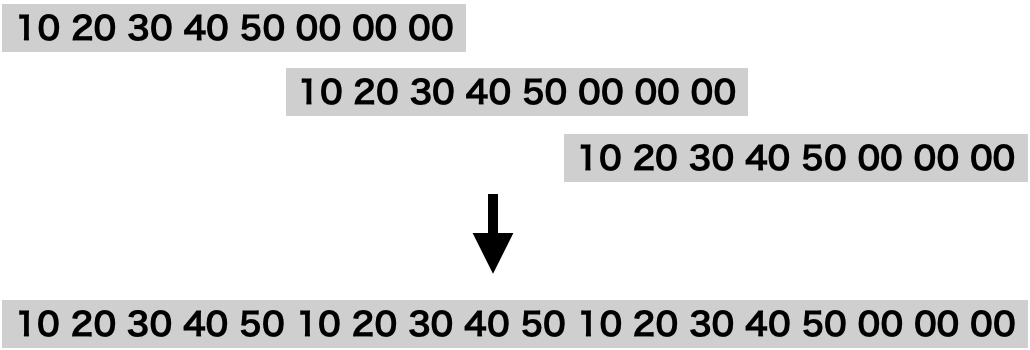">

以下がそのコードです。

In [ ]:
%%writefile measure.go
package main

import (
    "encoding/binary"
	"fmt"
	"math/rand"
	"time"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5 + 3]byte
 
	start := time.Now()
	for i := 0; i < count; i += 1 {
        for j := 0; j < size; j += 1 {
            binary.LittleEndian.PutUint64(buf[j*5:], ans[j])
        }
	}
	fmt.Println(time.Since(start))
 
    total := uint64(0)
    for i := 0; i < size * 5; i += 1 {
        total += uint64(buf[i])
    }
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

15.698051493s
63808521


素朴な実装とほぼ同じです。

次は`unsafe.Pointer()`で実装します。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5 + 3]byte

	start := time.Now()
	for i := 0; i < count; i += 1 {
        for j := 0; j < size; j += 1 {
            *(*uint64)(unsafe.Pointer(&buf[j*5])) = ans[j]
        }
	}
	fmt.Println(time.Since(start))
 
    total := uint64(0)
    for i := 0; i < size * 5; i += 1 {
        total += uint64(buf[i])
    }
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

11.661442364s
63808521


いよいよ本領を発揮しました。速いです。

## 5Nバイト配列から40bit整数の配列への変換

> `v = uint64(*(*uint32)(unsafe.Pointer(&buf[j]))) + uint64(buf[j+4]) << 32`がおすすめ

40bit整数が並んだバイト配列から整数を読み出す場合を測定しましょう。5バイトずつのバイト配列から10万個の整数を読み出します。素朴な実装は以下になります。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5]byte
 
    for j := 0; j < size; j += 1 {
        v := ans[j]
        *(*uint64)(unsafe.Pointer(&buf[j*5])) = v
    }

	start := time.Now()
    total := uint64(0)
    for i := 0; i < count; i += 1 {
        for j := 0; j < size * 5; j += 5 {
            b := buf[j:j+5]
            v := uint64(b[0])
            v += uint64(b[1]) << 8
            v += uint64(b[2]) << 16
            v += uint64(b[3]) << 24
            v += uint64(b[4]) << 32
            total += v
        }
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

23.22765755s
5692317074739218432


これが基準になります。

次にライブラリ使用で、5バイトのマスク。

In [ ]:
%%writefile measure.go
package main

import (
    "encoding/binary"
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5 + 3]byte
 
    for j := 0; j < size; j += 1 {
        v := ans[j]
        *(*uint64)(unsafe.Pointer(&buf[j*5])) = v
    }

	start := time.Now()
    total := uint64(0)
    for i := 0; i < count; i += 1 {
        for j := 0; j < size * 5; j += 5 {
            total += binary.LittleEndian.Uint64(buf[j:]) & 0xFF_FFFF_FFFF
        }
	}
	fmt.Println(time.Since(start))
 
    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

19.396402761s
5692317074739218432


少し改善。ただ、bufの領域を3バイト増やしています。

次はマスク外し。

In [ ]:
%%writefile measure.go
package main

import (
    "encoding/binary"
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5]byte
 
    for j := 0; j < size; j += 1 {
        v := ans[j]
        *(*uint64)(unsafe.Pointer(&buf[j*5])) = v
    }

	start := time.Now()
    total := uint64(0)
	for i := 0; i < count; i += 1 {
        for j := 0; j < size * 5; j += 5 {
            total += uint64(binary.LittleEndian.Uint32(buf[j:])) + uint64(buf[j+4]) << 32
        }
	}
	fmt.Println(time.Since(start))

    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

19.430706015s
5692317074739218432


ほぼ同じ。ただ、bufの領域はsize*5です。

次は`unsafe.Pointer()`かつ5バイトマスク。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5 + 3]byte
 
    for j := 0; j < size; j += 1 {
        v := ans[j]
        *(*uint64)(unsafe.Pointer(&buf[j*5])) = v
    }

	start := time.Now()
    total := uint64(0)
	for i := 0; i < count; i += 1 {
        for j := 0; j < size * 5; j += 5 {
            total += *(*uint64)(unsafe.Pointer(&buf[j])) & 0xFF_FFFF_FFFF
        }
	}
	fmt.Println(time.Since(start))

    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

11.731955237s
5692317074739218432


改善。ただ、bufは3バイト追加しています。

最後にマスク外し。

In [ ]:
%%writefile measure.go
package main

import (
	"fmt"
	"math/rand"
	"time"
    "unsafe"
)

func main() {
	const count = 100_000
    const size = 100_000
    var ans [size]uint64
    for i := 0; i < size; i += 1 {
    	ans[i] = uint64(rand.Intn(1<<40))
    }
	var buf [size * 5]byte
 
    for j := 0; j < size; j += 1 {
        v := ans[j]
        *(*uint64)(unsafe.Pointer(&buf[j*5])) = v
    }

	start := time.Now()
    total := uint64(0)
	for i := 0; i < count; i += 1 {
        for j := 0; j < size * 5; j += 5 {
            total += uint64(*(*uint32)(unsafe.Pointer(&buf[j]))) + uint64(buf[j+4]) << 32
        }
	}
	fmt.Println(time.Since(start))

    fmt.Println(total)
}

Overwriting measure.go


In [ ]:
!go run measure.go

11.740410912s
5692317074739218432


速度はほぼ同じ。ただ、bufのサイズはsize*5です。

結局、大きな配列に連続して40bit整数を書き込んだり読み込んだりするのには`unsafe.Pointer()`が有効でした。